In [178]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statistics
from statistics import mode

# Extract Data
***
## Read in Songs from Spotify API


In [154]:
#connecting to spotify API using Spotipy
cid ="12b051049eb14a05ac3dd252770b6bd3" 
secret = "8844a8e5f63f4fa3998ba69811b2e005"

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [162]:
artist_name = []
track_name = []
popularity = []
track_id = []
genres = []

#loading in 1000 different tracks from 2020 with Spotipy
for i in range(0,1000,10):
    track_results = sp.search(q='year:2010', type='track', limit=10,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        #populating lists we will use for DF later
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
        artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])
        genres.append(artist["genres"]) 

        

In [165]:

#storing data in dataframe
df_tracks = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity})

In [ ]:
## Extract Audio Features

In [ ]:
rows = []
batchsize = 100

#Create list of audio features for each song
for i in range(0,len(df_tracks['track_id']),batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t != None:
            rows.append(t)


In [6]:
# Storing audio feature data of each song in a dataframe
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
print("Shape of the dataset:", df_audio_features.shape)
df_audio_features.head()

Shape of the dataset: (1000, 18)


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.1120,https://api.spotify.com/v1/audio-analysis/6tDD...,0.653,160191,0.524,6tDDoYIxWvMLTdKpjFkc1B,0.000000,11,0.2030,-9.016,0,0.0502,83.970,4,https://api.spotify.com/v1/tracks/6tDDoYIxWvML...,audio_features,spotify:track:6tDDoYIxWvMLTdKpjFkc1B,0.553
1,0.1650,https://api.spotify.com/v1/audio-analysis/6s0Q...,0.699,83853,0.558,6s0QJ4tfTOkkkOMQz8HCrg,0.883000,9,0.0932,-14.713,1,0.0541,99.996,4,https://api.spotify.com/v1/tracks/6s0QJ4tfTOkk...,audio_features,spotify:track:6s0QJ4tfTOkkkOMQz8HCrg,0.398
2,0.4990,https://api.spotify.com/v1/audio-analysis/3YJJ...,0.436,279204,0.655,3YJJjQPAbDT7mGpX3WtQ9A,0.000008,1,0.6880,-8.370,0,0.0583,121.002,4,https://api.spotify.com/v1/tracks/3YJJjQPAbDT7...,audio_features,spotify:track:3YJJjQPAbDT7mGpX3WtQ9A,0.412
3,0.0299,https://api.spotify.com/v1/audio-analysis/2spP...,0.642,34750,0.749,2spPLfhb8c7rPxz28IdeXR,0.000000,6,0.2540,-7.060,0,0.2890,81.862,1,https://api.spotify.com/v1/tracks/2spPLfhb8c7r...,audio_features,spotify:track:2spPLfhb8c7rPxz28IdeXR,0.561
4,0.0212,https://api.spotify.com/v1/audio-analysis/5QO7...,0.680,215627,0.826,5QO79kh1waicV47BqGRL3g,0.000012,0,0.5430,-5.487,1,0.0309,118.051,4,https://api.spotify.com/v1/tracks/5QO79kh1waic...,audio_features,spotify:track:5QO79kh1waicV47BqGRL3g,0.644


# Create GMM 

In [107]:
# EM algo to create GMMs
def EM(dat, k, n):
    
    p_class=np.zeros(k)
    means=np.zeros((k,n))
    covars=np.zeros((k,n,n))
    mean_dist=np.array(0)
    p_data_given_class=np.zeros((len(dat),k))
    
    #initializations
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    
    for dim in range(k):
        covars[dim,:,:]=np.cov(np.transpose(dat))
        means[dim,:]=dat.iloc[init_idx[dim]]
        p_class[dim]=1/k
    
    for step in range(50):  
        #Bayes stuff: pdfs then pdf*mixtures, then normalize
        for dim in range(k):
            p_data_given_class[:,dim]=  np.array([stats.multivariate_normal.pdf(x=dat, mean=means[dim], cov=covars[dim])])
        p_class_given_data=p_data_given_class*p_class

        sums=np.sum(p_class_given_data, axis=1)
        for dim in range(k):
            p_class_given_data[:,dim]=p_class_given_data[:,dim]*(1/sums)
        n_class = np.sum(p_class_given_data, axis=0)
        p_class=n_class/len(dat)

        # mean and covar updates
        for dim in range(k):
            for f1 in range(n):
                means[dim,f1]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,f1])*(1/n_class[dim])
                
                for f2 in range(n):
                    if (f1==f2):
                        covars[dim,f1,f2]=np.sum(p_class_given_data[:,dim]*((dat.iloc[:,f1]-means[dim,f1])**2))*(1/n_class[dim])
                    else:
                        covars[dim,f1,f2]=np.sum(p_class_given_data[:,dim]*(dat.iloc[:,f1]-means[dim,f1])*(dat.iloc[:,f2]-means[dim,f2]))*(1/n_class[dim])   
                                                                 
    mean_dist=0
    
    for pt in range(len(dat)):
        for dim in range(k):
            #for each datum-mean pair, compute their prob-weighted distance apart
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
    mean_dist=mean_dist/(len(dat)*k)
    return p_class, means, covars, mean_dist, p_class_given_data

## Create GMM for k=2,4,6,8,10 clusters

In [87]:
# Create the GMMs with various K values to find the best K value to use
test_df = df_audio_features[['acousticness', 'energy', 'tempo', 'danceability', 'liveness', 'valence']]
test_df
p2, m2, c2,d2, pc2 = EM(test_df,2, 6)
p4, m4, c4,d4, pc4 = EM(test_df,4, 6)
p6, m6, c6,d6, pc6  = EM(test_df,6, 6)
p8, m8, c8,d8, pc8  = EM(test_df,8, 6)
p10, m10, c10,d10, pc10  = EM(test_df,10, 6)


## Decide which k value is the best to use

Text(0.5, 0, 'Distance')

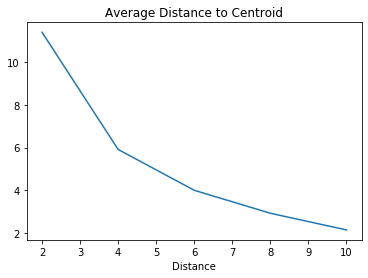

In [88]:
plt.plot([2,4,6,8,10], [d2,d4,d6,d8,d10])
plt.title('Average Distance to Centroid');
plt.xlabel("K")
plt.xlabel("Distance")

Using 6 Audio features, it appers the k=4 is the best k value to use.

## Create clusters

In [89]:
clusters = []
for pt in pc4:
    max_prob = max(pt)
    clusters.append(np.where(pt ==  max_prob)[0][0])


# Use PCA to find the two most related dimentasions for our plot

In [90]:
#PCA to find the two most related dimensions to plot
M = pd.DataFrame(test_df).values
MT = np.transpose(M)
MTM = np.matmul(MT, M)


#Decomposition of given data matrix
evals, evecs = np.linalg.eig(MTM)
np.sum(evecs[:,0]**2)
evals_sorted =  np.flip(np.sort(evals),0)

# Get the sorted list of indices for the eigenvalues
idx_sorted = [list(evals).index(ee) for ee in evals_sorted]

E = evecs[:,idx_sorted]
#Rotated M by E
ME2 = np.matmul(M, E[:,:2])

In [91]:
x = []
y = []
for i in range(ME2.shape[0]):
    x.append(ME2[i,0])
    y.append(ME2[i,1]) 

## Plot our clusters

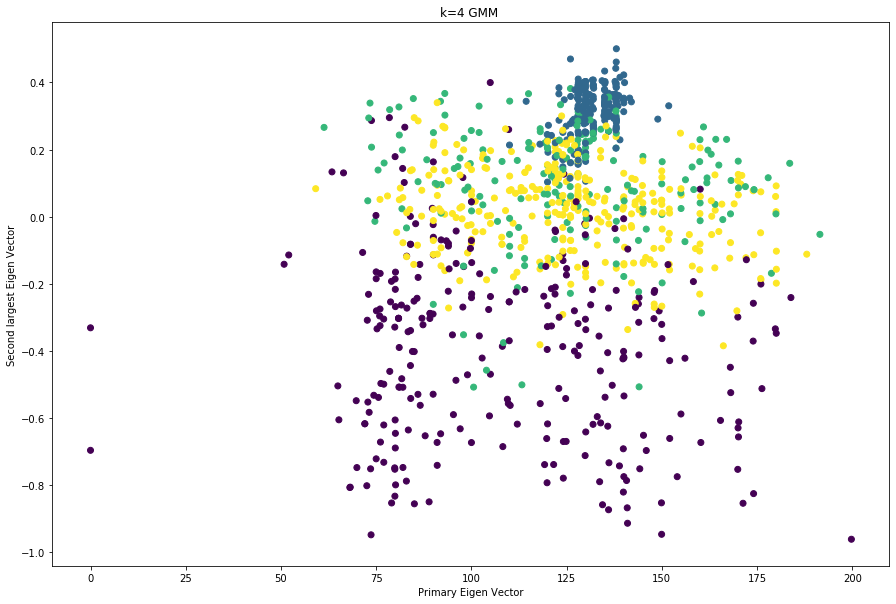

In [93]:
# Plot the clusters using the two most related dimensions
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('k=4 GMM ')
ax.scatter(x,y, c=clusters)
ax.set_xlabel('Primary Eigen Vector')
ax.set_ylabel('Second largest Eigen Vector')

# Find the most common genres from each cluster accoridng to Spotify

In [229]:
#print all the songs in the first cluster
index = 0
c1_genre = []
c2_genre = []
c3_genre = []
c4_genre = []
for song in clusters:
    if(song == 0):
        c1_genre.append(genres[index])
    if(song == 1):
        c2_genre.append(genres[index])
    if(song == 2):
        c3_genre.append(genres[index])
    if(song == 3):
        c4_genre.append(genres[index])
    index = index+1


In [239]:
c1_flat = [x for sublist in c1_genre for x in sublist]
c2_flat = [x for sublist in c2_genre for x in sublist]
c3_flat = [x for sublist in c3_genre for x in sublist]
c4_flat = [x for sublist in c4_genre for x in sublist]


In [267]:
def get_popular_genres(n, data):
    
    df=pd.DataFrame(data = {'Number': data})
    df1 = pd.DataFrame(df['Number'].value_counts())
    return  df1['Number'].index[:n,]

print("Cluster 1 most common genres: ",  get_popular_genres(4, c1_flat).values)
print("Cluster 2 most common genres: ",  get_popular_genres(4, c2_flat).values)
print("Cluster 3 most common genres: ",  get_popular_genres(4, c3_flat).values)
print("Cluster 4 most common genres: ",  get_popular_genres(4, c4_flat).values)



Cluster 1 most common genres:  ['pop' 'dance pop' 'post-teen pop' 'hip hop']
Cluster 2 most common genres:  ['country rock' 'rock' 'art rock' 'classic rock']
Cluster 3 most common genres:  ['pop' 'dance pop' 'post-teen pop' 'rap']
Cluster 4 most common genres:  ['pop' 'dance pop' 'post-teen pop' 'pop rap']


# Get the probabilty a new song belong to each cluster

## Gather 10 new songs

In [259]:
artist_name = []
track_name = []
popularity = []
track_id = []
genres = []

#loading in 10 different tracks from 2021 with Spotipy
for i in range(10):
    track_results = sp.search(q='year:2020', type='track', limit=1,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        #populating lists we will use for DF later
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
        artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])
        genres.append(artist["genres"]) 

In [260]:
#storing data in dataframe
df_new_tracks = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity})

In [261]:
df_new_tracks

,artist_name,track_name,track_id,popularity
0,Kali Uchis,telepatía,6tDDoYIxWvMLTdKpjFkc1B,95
1,Ema Spatula,Year 2020,6s0QJ4tfTOkkkOMQz8HCrg,17
2,SZA,Good Days,3YJJjQPAbDT7mGpX3WtQ9A,91
3,Armin van Buuren,A State Of Trance (ASOT 1012) - ASOT Yearmix 2...,2spPLfhb8c7rPxz28IdeXR,40
4,The Weeknd,Save Your Tears,5QO79kh1waicV47BqGRL3g,96
5,Hammock,Longest Year - 2020,51TAp7p7B3xboCl5HWmEkF,32
6,Giveon,Heartbreak Anniversary,3FAJ6O0NOHQV8Mc5Ri6ENp,93
7,Hammock,Dark Beyond the Blue - 2020,79hqdNpnWPVVxmZiDfKaIL,39
8,The Weeknd,Blinding Lights,0VjIjW4GlUZAMYd2vXMi3b,95
9,FUZZZY,Smile Year 2020 Pick up Line,2Uj2Vz9s4vcGSmiiiqWADs,19


In [262]:
rows = []
batchsize = 10

# Create list of audio features for each song
for i in range(0,len(df_new_tracks['track_id']),batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t != None:
            rows.append(t)

## Extract Audio Featureds

In [263]:
# Storing audio feature data of each song in a dataframe
df_new_audio_features = pd.DataFrame.from_dict(rows,orient='columns')


In [264]:
new_test_df = df_new_audio_features[['acousticness', 'energy', 'tempo', 'danceability', 'liveness', 'valence']]
new_test_df

,acousticness,energy,tempo,danceability,liveness,valence
0,0.512000,0.6060,145.837,0.523,0.1060,0.065
1,0.355000,0.4570,102.166,0.626,0.0668,0.474
2,0.013500,0.7660,127.007,0.794,0.0785,0.550
3,0.709000,0.4430,119.903,0.417,0.2170,0.470
4,0.045500,0.4380,185.716,0.247,0.1110,0.390
5,0.000717,0.8660,127.009,0.585,0.1590,0.450
6,0.015100,0.8430,109.012,0.637,0.0876,0.434
7,0.172000,0.5760,150.840,0.265,0.0896,0.225
8,0.002960,0.8820,120.016,0.699,0.1300,0.657
9,0.969000,0.0855,69.893,0.314,0.1600,0.161


## Get the probability a song belongs to each cluster

In [265]:
# Method to compute the probabilty a new song belongs to each genre (cluster)
def p_class_given_data(song, k, means, covars, p_class):
    p_song_given_cluster = []
    p_cluster_given_song = []
    for cluster in range(k):
        p_song_given_cluster.append( stats.multivariate_normal.pdf(x=song, mean=means[cluster], cov=covars[cluster]))
        p_cluster_given_song.append( p_song_given_cluster[cluster] * p_class[cluster] )
    
    summ = sum(p_cluster_given_song)
    
    for cluster in range(k):
        p_cluster_given_song[cluster] = p_cluster_given_song[cluster] / summ
    
    return  p_cluster_given_song

In [266]:
for index in range(10):
    song = list(new_test_df.iloc[index].values)
    print(df_new_tracks.iloc[index]['track_name'], "has genres", genres[index])
    probs = p_class_given_data(song, 4, m4, c4, p4)


    print("probability of belonging to cluster 0 with genres", get_popular_genres(4, c1_flat).values, ":", probs[0].round(4))
    print("probability of belonging to cluster 1 with genres", get_popular_genres(4, c2_flat).values, ":", probs[1].round(4))
    print("probability of belonging to cluster 2 with genres", get_popular_genres(4, c3_flat).values, ":", probs[2].round(4))
    print("probability of belonging to cluster 3 with genres", get_popular_genres(4, c4_flat).values, ":", probs[3].round(4))
    print("")

    

telepatía has genres ['colombian pop', 'pop']
probability of belonging to cluster 0 with genres ['pop' 'dance pop' 'post-teen pop' 'hip hop'] : 0.9972
probability of belonging to cluster 1 with genres ['country rock' 'rock' 'art rock' 'classic rock'] : 0.0
probability of belonging to cluster 2 with genres ['pop' 'dance pop' 'post-teen pop' 'rap'] : 0.0028
probability of belonging to cluster 3 with genres ['pop' 'dance pop' 'post-teen pop' 'pop rap'] : 0.0

Year 2020 has genres []
probability of belonging to cluster 0 with genres ['pop' 'dance pop' 'post-teen pop' 'hip hop'] : 0.9798
probability of belonging to cluster 1 with genres ['country rock' 'rock' 'art rock' 'classic rock'] : 0.0
probability of belonging to cluster 2 with genres ['pop' 'dance pop' 'post-teen pop' 'rap'] : 0.0027
probability of belonging to cluster 3 with genres ['pop' 'dance pop' 'post-teen pop' 'pop rap'] : 0.0175

Good Days has genres ['pop', 'pop rap', 'r&b']
probability of belonging to cluster 0 with genres 